In [275]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

В датасете пропущенные данные заменены знаком ?, заменяем их на np.nan и дропаем все строки с пропущенными данным, чтобы было проще анализировать их

In [288]:
data = pd.read_csv('train.tsv', sep='\t')
data = data.replace('?', np.nan)
data = data.dropna()

Сначала предобработаем данные, alchemy_category с помощью LabelEncoder()

In [289]:
le = preprocessing.LabelEncoder()

le.fit(list(set(data.alchemy_category)))
data.alchemy_category = le.transform(data.alchemy_category)

boilerplate содержит json в котором есть заголовок, аннотация и url ссылка. Можно разбить его на три признака и дальше при желании получить эмбединги и обучиться на них

In [290]:
import json
json.loads(data.boilerplate.iloc[0]).keys()

dict_keys(['title', 'body', 'url'])

In [291]:
titles = list()
bodies = list()
urls = list()

for i in range(data.shape[0]):
    try:
        if json.loads(data.boilerplate.iloc[i])['title'] is None:
            titles.append(json.loads(''))
        else:
            titles.append(json.loads(data.boilerplate.iloc[i])['title'])
    except Exception:
        titles.append('')
    try:
        if json.loads(data.boilerplate.iloc[i])['body'] is None:
            bodies.append(json.loads(''))
        else:
            bodies.append(json.loads(data.boilerplate.iloc[i])['body'])
    except Exception:
        bodies.append('')
    try:
        if json.loads(data.boilerplate.iloc[i])['url'] is None:
            urls.append(json.loads(''))
        else:
            urls.append(json.loads(data.boilerplate.iloc[i])['url'])
    except Exception:
        urls.append('')        

In [287]:
data = data.assign(boilerplate_title=titles)
data = data.assign(boilerplate_body=bodies)
data = data.assign(boilerplate_url=urls)

In [281]:
data = data.drop('url', axis=1) 
data = data.drop('boilerplate', axis=1)
data = data.drop('framebased', axis=1)

In [282]:
data.head()

,urlid,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,...,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label,boilerplate_title,boilerplate_body,boilerplate_url
0,4042,1,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,...,0,5424,170,8,0.152941,0.079130,0,IBM Sees Holographic Calls Air Breathing Batte...,A sign stands outside the International Busine...,bloomberg news 2010 12 23 ibm predicts hologra...
1,8471,7,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,0.468649,0.0,...,0,4973,187,9,0.181818,0.125448,1,The Fully Electronic Futuristic Starting Gun T...,And that can be carried on a plane without the...,popsci technology article 2012 07 electronic f...
2,1164,5,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,0.525448,0.0,...,0,2240,258,11,0.166667,0.057613,1,Fruits that Fight the Flu fruits that fight th...,Apples The most popular source of antioxidants...,menshealth health flu fighting fruits cm mmc F...
3,6684,5,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,0.480725,0.0,...,0,2737,120,5,0.041667,0.100858,1,10 Foolproof Tips for Better Sleep,There was a period in my life when I had a lot...,dumblittleman 2007 12 10 foolproof tips for be...
4,9006,10,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,0.446143,0.0,...,0,12032,162,10,0.098765,0.082569,0,The 50 Coolest Jerseys You Didn t Know Existed...,Jersey sales is a curious business Whether you...,bleacherreport articles 1205138 the 50 coolest...


In [283]:
corr = data.corr()

Построим корреляционнаую матрицу

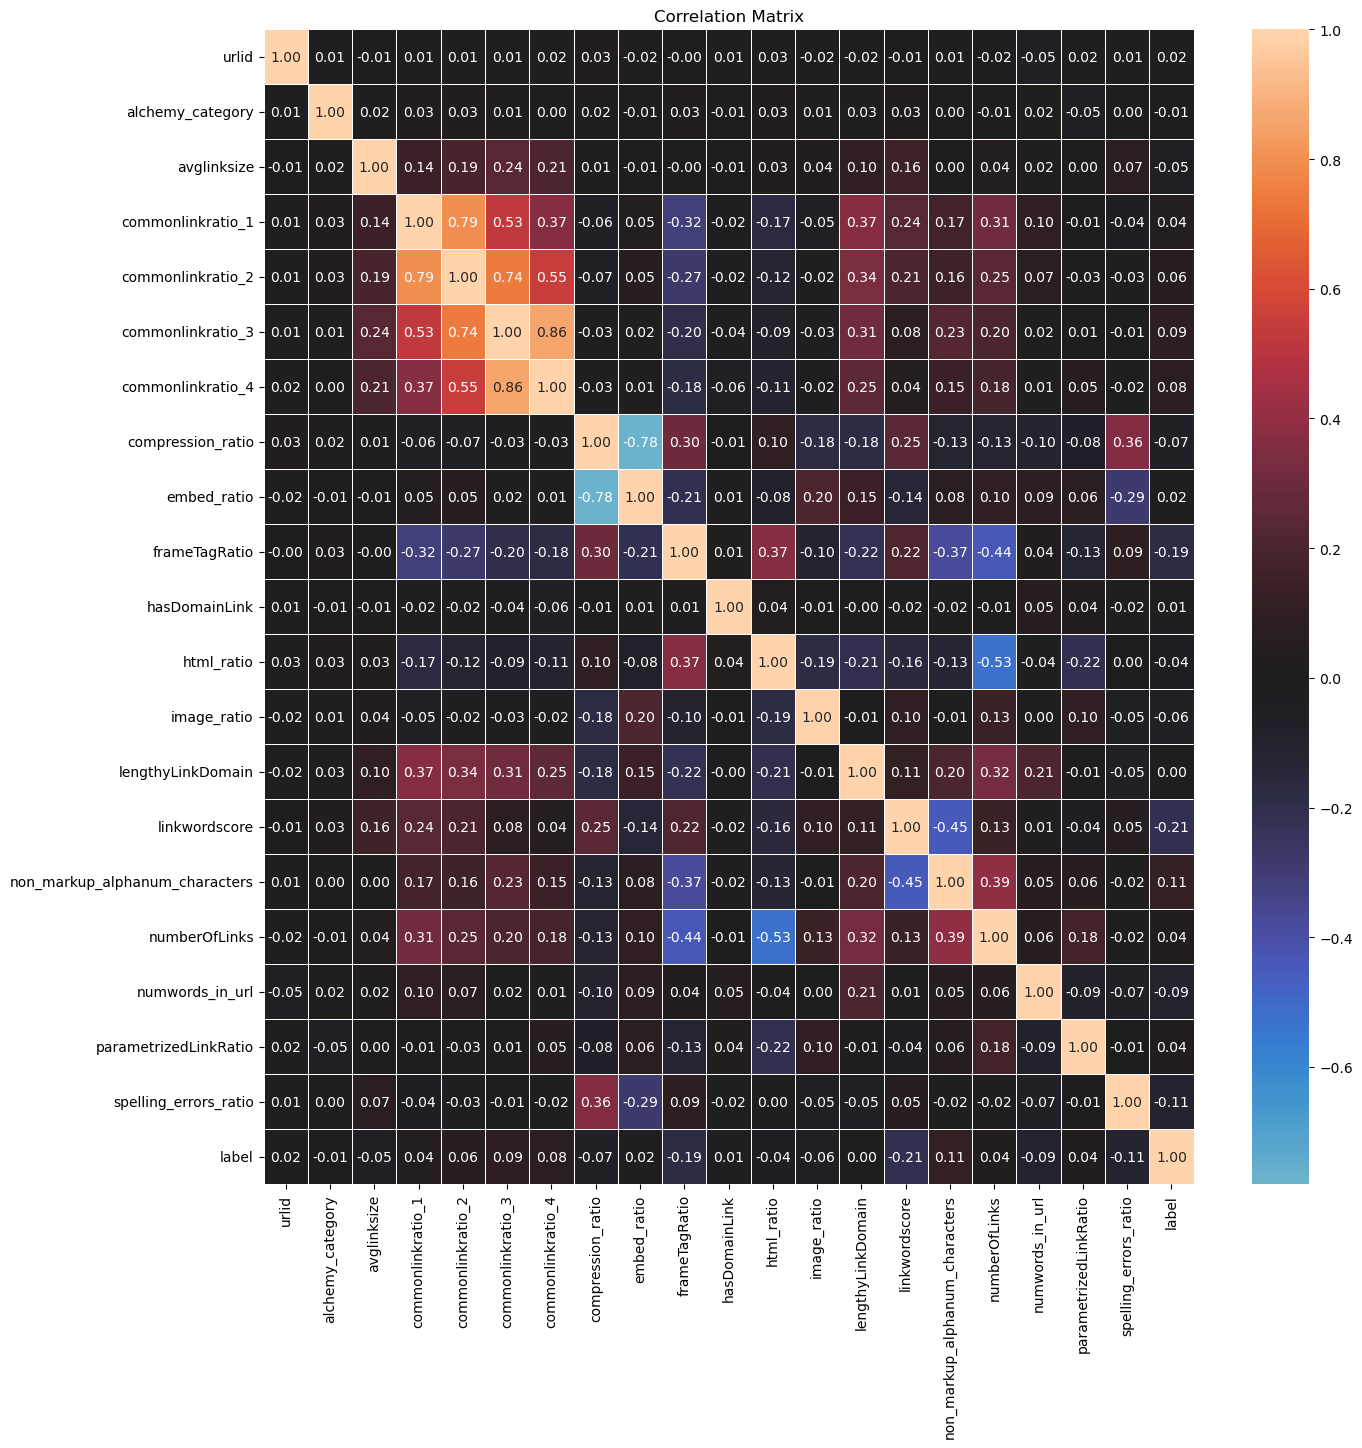

In [284]:
import seaborn as sns
import matplotlib.pyplot as plt


f, ax = plt.subplots(figsize=(15, 15))
plt.title('Correlation Matrix')
ax = sns.heatmap(corr, annot=True, fmt=".2f", linewidths=.5, center=0) 
plt.show()

В датасете 21 признак и вручную экспертно разбираться что от чего зависит очень сложно, поэтому была придумана следующая схема получения графа:
    
1) строим корреляционную матрицу;

2) зануляем глафную диагональ, чтобы не было петель;

3) задаем порог модуля коррреляции, по которому будем принимать решение, есть ли ребро между вершинами или нет. 

После этого получаем матрицу смежности, которую уже экспертно преобразуем в ориентированный граф

In [292]:
for i in corr.columns:
    corr[i] = corr[i].apply(lambda x: 0 if x == 1 else x)
    
for i in corr.columns:
    corr[i] = corr[i].apply(lambda x: -x if x  < 0 else x)    
    
for i in corr.columns:
    corr[i] = corr[i].apply(lambda x: 0 if x  < 0.18 else 1)       

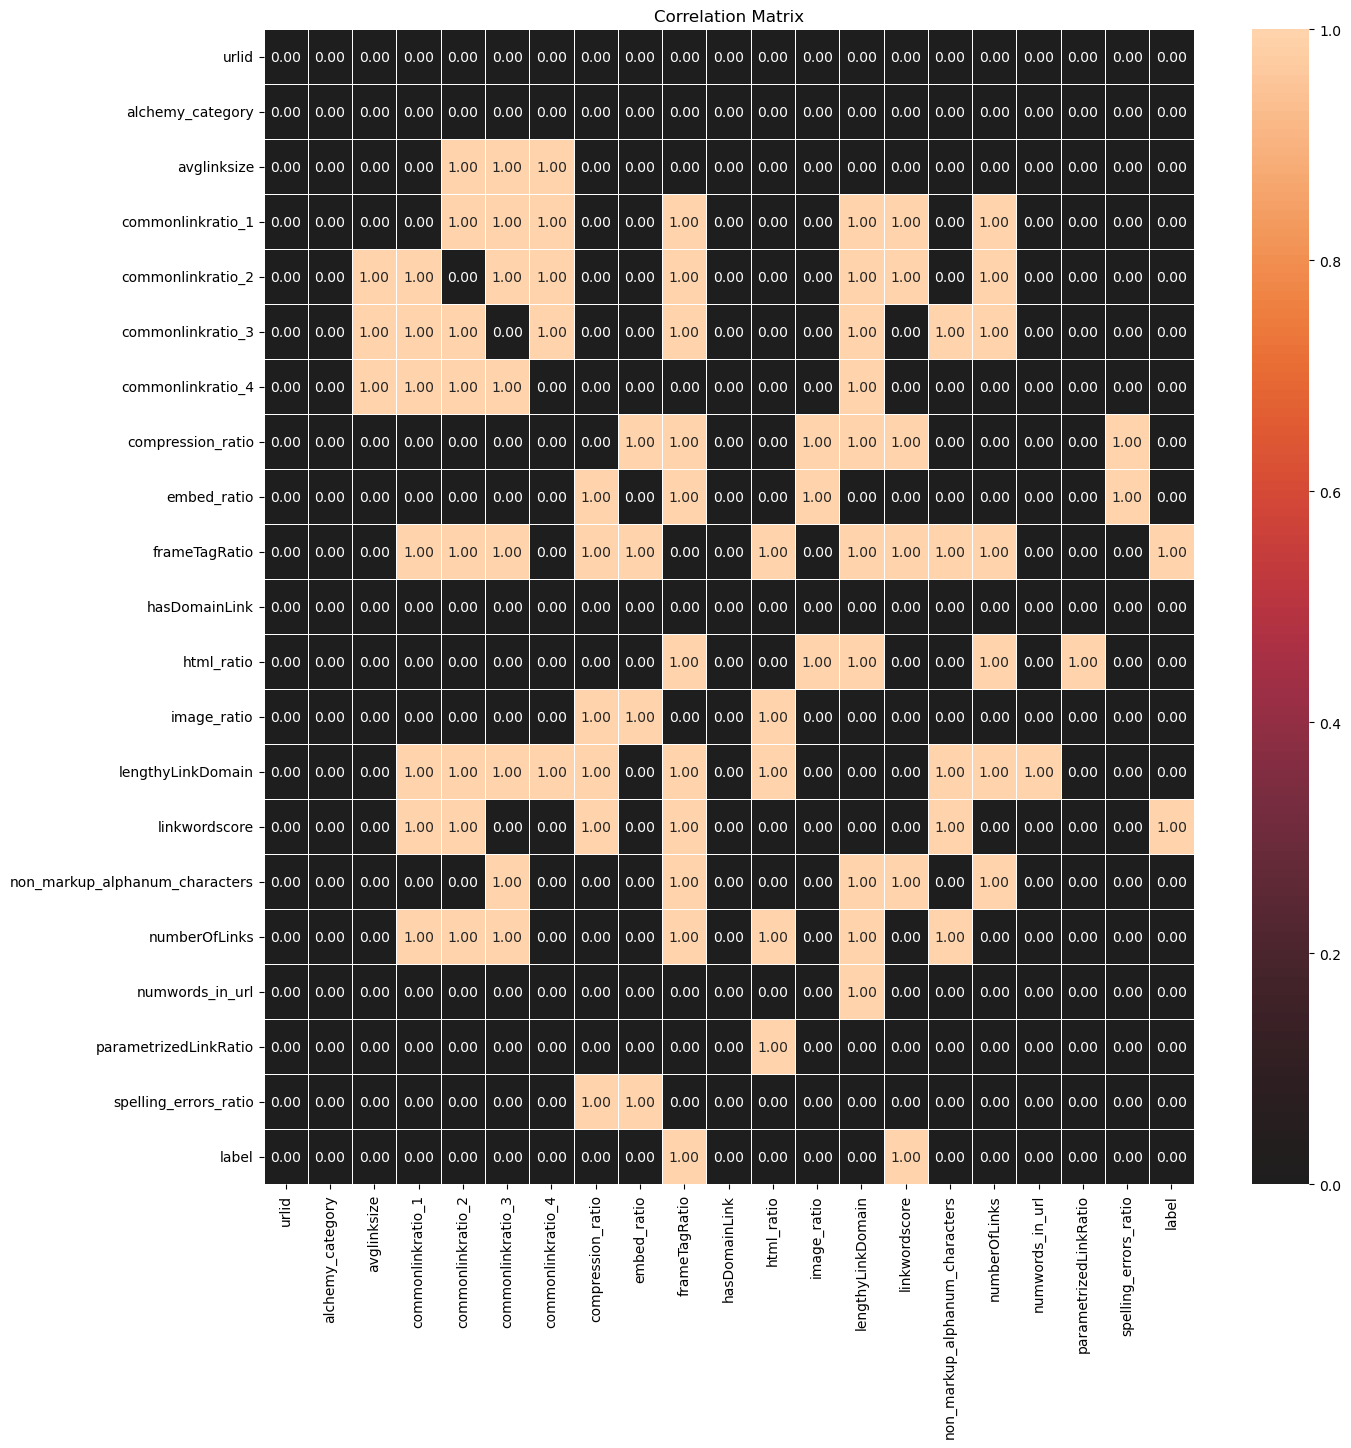

In [293]:
import seaborn as sns
import matplotlib.pyplot as plt


f, ax = plt.subplots(figsize=(15, 15))
plt.title('Correlation Matrix')
ax = sns.heatmap(corr, annot=True, fmt=".2f", linewidths=.5, center=0) 
plt.show()

Заводим служебные словари - mapping для задания имен ребер при создании графа networkx и name_to_id для обращения к ячейке матрицы смежности по имени, а не по индексу

In [294]:
mapping = {
    i : corr.columns[i] for i in range(corr.columns.shape[0])
}

In [295]:
name_to_id = {
    corr.columns[i] : i for i in range(corr.columns.shape[0])
}

In [296]:
import networkx as nx

In [297]:
adjency_matrix = corr.as_matrix()
adjency_matrix

/home/mivankin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,

Дополнительная функция, для проверки симметричности матрицы. Если хотя бы один элемент в матрице симметричен, то считаем, что не до конца провели анализ и граф имеет дуги.

In [298]:
def check_symmetric(a,):
    result = list()
    ans = False
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            if a[i,j] == a[j,i] and a[i,j] == 1:
                result.append([i, j])
                ans = True
    
    print(result)
    return ans, result

ans, ind = check_symmetric(adjency_matrix)
ans

[[2, 4], [2, 5], [2, 6], [3, 4], [3, 5], [3, 6], [3, 9], [3, 13], [3, 14], [3, 16], [4, 2], [4, 3], [4, 5], [4, 6], [4, 9], [4, 13], [4, 14], [4, 16], [5, 2], [5, 3], [5, 4], [5, 6], [5, 9], [5, 13], [5, 15], [5, 16], [6, 2], [6, 3], [6, 4], [6, 5], [6, 13], [7, 8], [7, 9], [7, 12], [7, 13], [7, 14], [7, 19], [8, 7], [8, 9], [8, 12], [8, 19], [9, 3], [9, 4], [9, 5], [9, 7], [9, 8], [9, 11], [9, 13], [9, 14], [9, 15], [9, 16], [9, 20], [11, 9], [11, 12], [11, 13], [11, 16], [11, 18], [12, 7], [12, 8], [12, 11], [13, 3], [13, 4], [13, 5], [13, 6], [13, 7], [13, 9], [13, 11], [13, 15], [13, 16], [13, 17], [14, 3], [14, 4], [14, 7], [14, 9], [14, 15], [14, 20], [15, 5], [15, 9], [15, 13], [15, 14], [15, 16], [16, 3], [16, 4], [16, 5], [16, 9], [16, 11], [16, 13], [16, 15], [17, 13], [18, 11], [19, 7], [19, 8], [20, 9], [20, 14]]


True

In [299]:
corr.columns

Index(['urlid', 'alchemy_category', 'avglinksize', 'commonlinkratio_1',
       'commonlinkratio_2', 'commonlinkratio_3', 'commonlinkratio_4',
       'compression_ratio', 'embed_ratio', 'frameTagRatio', 'hasDomainLink',
       'html_ratio', 'image_ratio', 'lengthyLinkDomain', 'linkwordscore',
       'non_markup_alphanum_characters', 'numberOfLinks', 'numwords_in_url',
       'parametrizedLinkRatio', 'spelling_errors_ratio', 'label'],
      dtype='object')

В датасете представлены следующие признаки

url	string	URL-адрес классифицируемой веб-страницы

urlid	integer	StumbleUpon's уникальный идентификатор страницы

boilerplate	json	Boilerplate текст

alchemy_category	string	Alchemy категории (согласно общедоступному Alchemy API, находящемуся на сайте www.alchemyapi.com)

avglinksize	double	Среднее количество слов в каждой ссылке

commonLinkRatio_1	double	Количество ссылок, разделяющих хотя бы 1 слово с 1 другими ссылками / количество ссылок

commonLinkRatio_2	double	Количество ссылок, разделяющих хотя бы 1 слово с 2 другими ссылками / количество ссылок

commonLinkRatio_3	double	Количество ссылок, разделяющих хотя бы 1 слово с 3 другими ссылками / количество ссылок

commonLinkRatio_4	double	Количество ссылок, разделяющих хотя бы 1 слово с 4 другими ссылками / количество ссылок

compression_ratio	double	Сжатие достигается на этой странице с помощью gzip (мера избыточности)

embed_ratio	double	Подсчет количества использования <embed>

frameBased	integer (0 or 1)	Страница основана на фреймах (1), если у нее нет разметки основного текста, но есть разметка набора фреймов.

frameTagRatio	double	Отношение разметок iframe к общему количеству разметок

hasDomainLink	integer (0 or 1)	Истинно (1), если он содержит URL-адрес с доменом
    
html_ratio	double	Соотношение тегов и текста на странице

image_ratio	double	Соотношение тегов <img> и текста на странице

is_news	integer (0 or 1)	Истина (1), если классификатор новостей StumbleUpon определяет, что эта веб-страница является новостной.

lengthyLinkDomain	integer (0 or 1)	Истинно (1), если хотя бы 3-й текст содержит более 30 буквенно-цифровых символов
    
linkwordscore	double	Процент слов на странице, которые находятся в тексте гиперссылки

news_front_page	integer (0 or 1)	Истина (1), если классификатор новостей StumbleUpon определяет, что эта веб-страница является новостью первой страницы.

non_markup_alphanum_characters	integer	Количество буквенно-цифровых символов в тексте страницы

numberOfLinks	integer	Количество ссылок
    
numwords_in_url	double	Количество слов в url

parametrizedLinkRatio	double	Ссылка параметризуется, если ее URL-адрес содержит параметры или имеет прикрепленное событие onClick.

spelling_errors_ratio	double	Соотношение слов, не найденных в вики (считается орфографической ошибкой)

label	integer (0 or 1)	User-determined label. Either evergreen (1) or non-evergreen (0); available for train.tsv only

На основе анализа было принято решение занулить следующие направления ребер

In [300]:
adjency_matrix[name_to_id['label'], name_to_id['frameTagRatio']] = 0
adjency_matrix[name_to_id['label'], name_to_id['linkwordscore']] = 0
adjency_matrix[name_to_id['linkwordscore'], name_to_id['frameTagRatio']] = 0
adjency_matrix[name_to_id['linkwordscore'], name_to_id['embed_ratio']] = 0
adjency_matrix[name_to_id['compression_ratio'], name_to_id['spelling_errors_ratio']] = 0
adjency_matrix[name_to_id['spelling_errors_ratio'], name_to_id['embed_ratio']] = 0
adjency_matrix[name_to_id['compression_ratio'], name_to_id['embed_ratio']] = 0
adjency_matrix[name_to_id['embed_ratio'], name_to_id['image_ratio']] = 0
adjency_matrix[name_to_id['compression_ratio'], name_to_id['image_ratio']] = 0
adjency_matrix[name_to_id['html_ratio'], name_to_id['image_ratio']] = 0

adjency_matrix[name_to_id['frameTagRatio'], name_to_id['compression_ratio']] = 0
adjency_matrix[name_to_id['frameTagRatio'], name_to_id['embed_ratio']] = 0
adjency_matrix[name_to_id['frameTagRatio'], name_to_id['non_markup_alphanum_characters']] = 0
adjency_matrix[name_to_id['frameTagRatio'], name_to_id['numberOfLinks']] = 0

adjency_matrix[name_to_id['lengthyLinkDomain'], name_to_id['numwords_in_url']] = 0
adjency_matrix[name_to_id['parametrizedLinkRatio'], name_to_id['html_ratio']] = 0
adjency_matrix[name_to_id['linkwordscore'], name_to_id['html_ratio']] = 0

adjency_matrix[name_to_id['html_ratio'], name_to_id['lengthyLinkDomain']] = 0
adjency_matrix[name_to_id['html_ratio'], name_to_id['numberOfLinks']] = 0
adjency_matrix[name_to_id['html_ratio'], name_to_id['commonlinkratio_1']] = 0

adjency_matrix[name_to_id['html_ratio'], name_to_id['parametrizedLinkRatio']] = 0
adjency_matrix[name_to_id['numberOfLinks'], name_to_id['parametrizedLinkRatio']] = 0
adjency_matrix[name_to_id['numberOfLinks'], name_to_id['commonlinkratio_3']] = 0
adjency_matrix[name_to_id['numberOfLinks'], name_to_id['commonlinkratio_1']] = 0
adjency_matrix[name_to_id['numberOfLinks'], name_to_id['commonlinkratio_2']] = 0
adjency_matrix[name_to_id['numberOfLinks'], name_to_id['commonlinkratio_4']] = 0

adjency_matrix[name_to_id['compression_ratio'], name_to_id['lengthyLinkDomain']] = 0
adjency_matrix[name_to_id['linkwordscore'], name_to_id['compression_ratio']] = 0
adjency_matrix[name_to_id['linkwordscore'], name_to_id['commonlinkratio_1']] = 0
adjency_matrix[name_to_id['linkwordscore'], name_to_id['commonlinkratio_2']] = 0
adjency_matrix[name_to_id['non_markup_alphanum_characters'], name_to_id['commonlinkratio_1']] = 0
adjency_matrix[name_to_id['non_markup_alphanum_characters'], name_to_id['lengthyLinkDomain']] = 0
adjency_matrix[name_to_id['linkwordscore'], name_to_id['non_markup_alphanum_characters']] = 0
adjency_matrix[name_to_id['non_markup_alphanum_characters'], name_to_id['commonlinkratio_3']] = 0
adjency_matrix[name_to_id['non_markup_alphanum_characters'], name_to_id['numberOfLinks']] = 0
adjency_matrix[name_to_id['avglinksize'], name_to_id['linkwordscore']] = 0
adjency_matrix[name_to_id['avglinksize'], name_to_id['commonlinkratio_3']] = 0
adjency_matrix[name_to_id['avglinksize'], name_to_id['commonlinkratio_4']] = 0
adjency_matrix[name_to_id['avglinksize'], name_to_id['commonlinkratio_2']] = 0
adjency_matrix[name_to_id['avglinksize'], name_to_id['lengthyLinkDomain']] = 0

adjency_matrix[name_to_id['lengthyLinkDomain'], name_to_id['frameTagRatio']] = 0
adjency_matrix[name_to_id['frameTagRatio'], name_to_id['html_ratio']] = 0

adjency_matrix[name_to_id['lengthyLinkDomain'], name_to_id['commonlinkratio_1']] = 0
adjency_matrix[name_to_id['lengthyLinkDomain'], name_to_id['commonlinkratio_2']] = 0
adjency_matrix[name_to_id['lengthyLinkDomain'], name_to_id['commonlinkratio_3']] = 0
adjency_matrix[name_to_id['lengthyLinkDomain'], name_to_id['commonlinkratio_4']] = 0
adjency_matrix[name_to_id['lengthyLinkDomain'], name_to_id['alchemy_category']] = 0
adjency_matrix[name_to_id['lengthyLinkDomain'], name_to_id['numberOfLinks']] = 0

adjency_matrix[name_to_id['lengthyLinkDomain'], name_to_id['frameTagRatio']] = 0

adjency_matrix[name_to_id['frameTagRatio'], name_to_id['commonlinkratio_3']] = 0
adjency_matrix[name_to_id['frameTagRatio'], name_to_id['commonlinkratio_2']] = 0
adjency_matrix[name_to_id['frameTagRatio'], name_to_id['commonlinkratio_1']] = 0

adjency_matrix[name_to_id['commonlinkratio_1'], name_to_id['commonlinkratio_2']] = 0
adjency_matrix[name_to_id['commonlinkratio_1'], name_to_id['commonlinkratio_3']] = 0
adjency_matrix[name_to_id['commonlinkratio_1'], name_to_id['commonlinkratio_4']] = 0
adjency_matrix[name_to_id['commonlinkratio_2'], name_to_id['commonlinkratio_3']] = 0
adjency_matrix[name_to_id['commonlinkratio_2'], name_to_id['commonlinkratio_4']] = 0
adjency_matrix[name_to_id['commonlinkratio_3'], name_to_id['commonlinkratio_4']] = 0

Построим граф

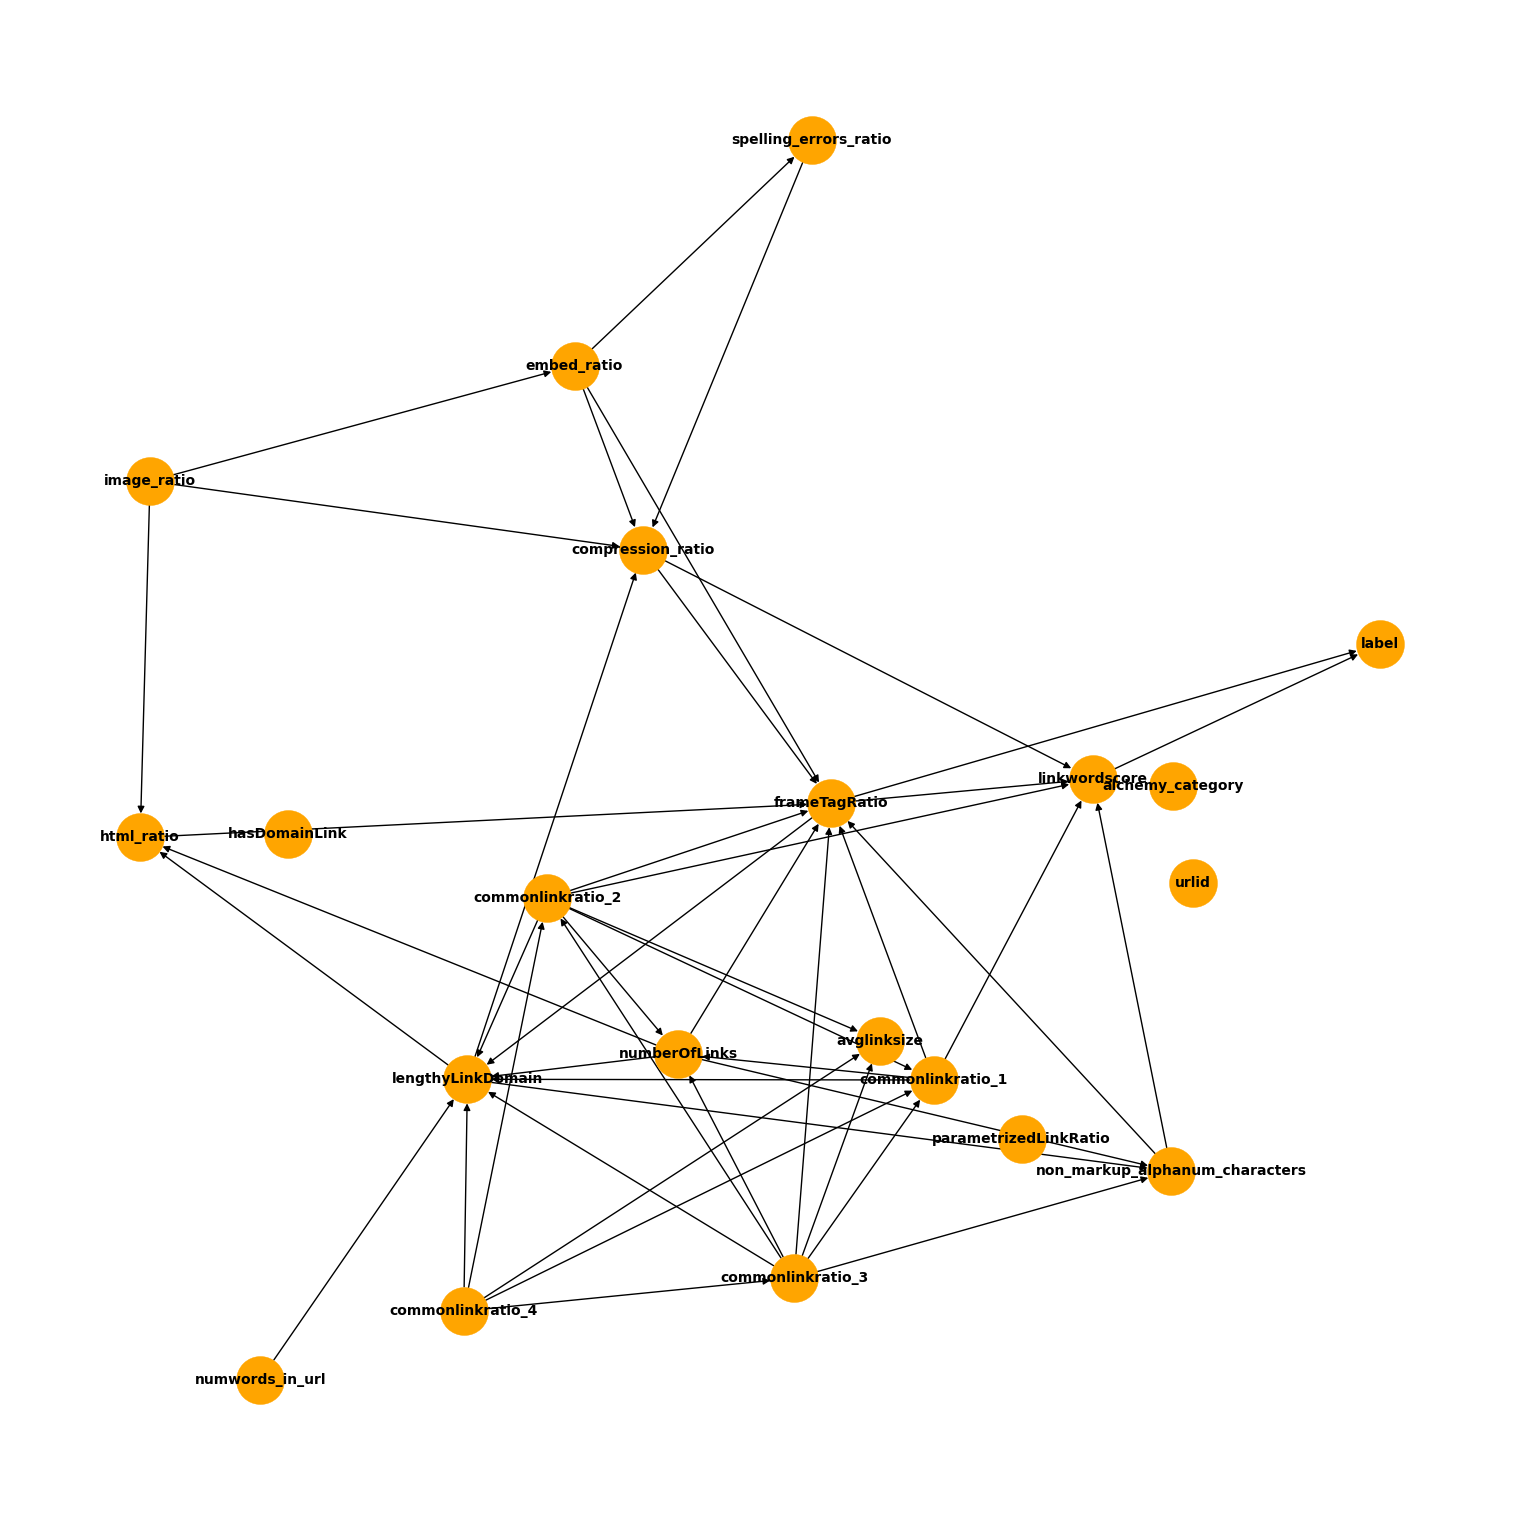

In [303]:
from networkx.drawing.layout import kamada_kawai_layout
G = nx.DiGraph()
G=nx.from_numpy_matrix(adjency_matrix, create_using=nx.DiGraph)
G = nx.relabel_nodes(G, mapping)
pos = kamada_kawai_layout(G, scale=10)
plt.figure(figsize=(15,15))

nx.draw(G, pos = kamada_kawai_layout(G), \
    node_size=1200, node_color='orange', linewidths=0.25, \
    font_size=10, font_weight='bold', with_labels=True)
plt.show()

Для анализа в dowhy представим бинарные признаки в виде boolean

In [304]:
data.label = data.label.apply(lambda x: True if x == 1 else False)
data.hasDomainLink = data.hasDomainLink.apply(lambda x: True if x == 1 else False)

In [305]:
nx.write_gml(G, "test.gml")
with open('test.gml') as f:
    grapth = f.read()

In [306]:
from dowhy import CausalModel

In [322]:
model = CausalModel(
    data=data,
    treatment='label',
    outcome='hasDomainLink',
    graph=grapth.replace("\n", " "))

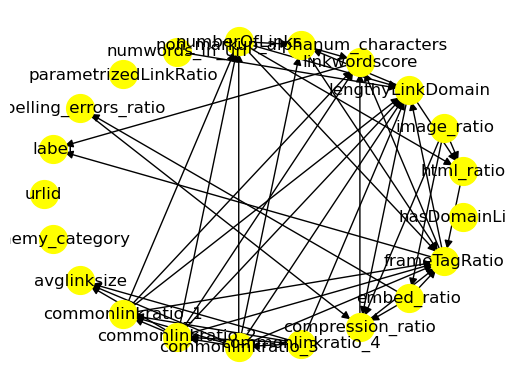

In [323]:
model.view_model(layout="twopi")
plt.show()

In [324]:
import statsmodels
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(hasDomainLink|commonlinkratio_1,lengthyLinkDomain,non_mar
d[label]                                                                      

                                                                              
kup_alphanum_characters,image_ratio,commonlinkratio_3,urlid,html_ratio,compres
                                                                              

                                                                              
sion_ratio,commonlinkratio_4,numberOfLinks,spelling_errors_ratio,alchemy_categ
                                                                              

                                                                              
ory,embed_ratio,parametrizedLinkRatio,avglinksize,commonlinkratio_2,numwords_i
                                

In [325]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_stratification",target_units="ate")
# ATE = Average Treatment Effect
# ATT = Average Treatment Effect on Treated 
# ATC = Average Treatment Effect on Control
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(hasDomainLink|commonlinkratio_1,lengthyLinkDomain,non_mar
d[label]                                                                      

                                                                              
kup_alphanum_characters,image_ratio,commonlinkratio_3,urlid,html_ratio,compres
                                                                              

                                                                              
sion_ratio,commonlinkratio_4,numberOfLinks,spelling_errors_ratio,alchemy_categ
                                                                              

                                                                              
ory,embed_ratio,parametrizedLinkRatio,avglinksize,commonlinkrat

In [326]:
refute_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute_results)

Refute: Add a Random Common Cause
Estimated effect:0.0021524062319634735
New effect:0.0017571200342340978



In [327]:
model = CausalModel(
    data=data,
    treatment='label',
    outcome='non_markup_alphanum_characters',
    graph=grapth.replace("\n", " "))

In [328]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(non_markup_alphanum_characters|commonlinkratio_1,lengthyL
d[label]                                                                      

                                                                              
inkDomain,image_ratio,commonlinkratio_3,urlid,linkwordscore,html_ratio,compres
                                                                              

                                                                              
sion_ratio,commonlinkratio_4,numberOfLinks,spelling_errors_ratio,alchemy_categ
                                                                              

                                                                              
ory,embed_ratio,parametrizedLinkRatio,avglinksize,commonlinkratio_2,numwords_i
                                

In [329]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_stratification",target_units="ate")
# ATE = Average Treatment Effect
# ATT = Average Treatment Effect on Treated 
# ATC = Average Treatment Effect on Control
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(non_markup_alphanum_characters|commonlinkratio_1,lengthyL
d[label]                                                                      

                                                                              
inkDomain,image_ratio,commonlinkratio_3,urlid,linkwordscore,html_ratio,compres
                                                                              

                                                                              
sion_ratio,commonlinkratio_4,numberOfLinks,spelling_errors_ratio,alchemy_categ
                                                                              

                                                                              
ory,embed_ratio,parametrizedLinkRatio,avglinksize,commonlinkrat

In [330]:
# Adds randomly drawn covariates to data and re-runs the analysis to see if the 
# causal estimate changes or not. If our assumption was originally correct then 
# the causal estimate shouldn’t change by much.
refute_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute_results)

Refute: Add a Random Common Cause
Estimated effect:-357.3683018516029
New effect:151.04593161967546



In [331]:
#Randomly assigns any covariate as a treatment and re-runs the analysis. If our 
# assumptions were correct then this newly found out estimate should go to 0.
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute", proceed_when_unidentifiable=True)
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:-357.3683018516029
New effect:14.077598299497447
p value:0.5



In [332]:
#Creates subsets of the data(similar to cross-validation) and checks whether the 
# causal estimates vary across subsets. If our assumptions were correct there shouldn’t be much variation.
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

Refute: Use a subset of data
Estimated effect:-357.3683018516029
New effect:-265.8487962101382
p value:0.36

